In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import argparse
import itertools
import json
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from sklearn.metrics import confusion_matrix

In [3]:
pd.options.display.max_rows = 999

In [4]:
def get_confusion_matrix(json_files, is_fine=False, all_label_sets_ordered=None):
    results_dicts = []
    for json_file in json_files:
        with open(json_file, 'r') as json_data:
            results_dicts.append(json.load(json_data))
    json_gold_pred = "label_set_info (id/gold/pred)"
    json_gold_pred_fine = "id_gold_pred_fine"
    json_cm = 'confusion_matrix'
    if is_fine:
        json_gold_pred = json_gold_pred_fine
        json_cm += '_fine'
    id_gold_preds = []
    binary_confusion_matrix = np.zeros((6,2,2))
    for results_dict in results_dicts:
        id_gold_preds.append(results_dict[json_gold_pred])
        binary_confusion_matrix += np.array(results_dict[json_cm])
    
    n_rows = 3
    n_cols = 2
    n_classes = 2
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    row_idx, col_idx = 0, 0
    for idx, cm in enumerate(binary_confusion_matrix):
        ax = axes[row_idx, col_idx]
        ax.set_title(class_labels[idx])
        #ax.set_ylabel('True')
        #ax.set_xlabel('Predicted')
        ax.imshow(cm, interpolation='nearest', cmap='Wistia')
        s = [['TN','FP'], ['FN', 'TP']]
        for i in range(2):
            for j in range(2):
                #ax.text(j,i, str(s[i][j])+"="+str(cm[i][j]))
                ax.text(j,i, str(cm[i][j])+"("+str((cm[i][j]/np.array(cm).sum(axis=1)*100)[i])[:4]+"%)")
        ax.set(xticks=np.arange(n_classes),
               yticks=np.arange(n_classes),
               xticklabels=[0,1],
               yticklabels=[0,1],
               ylabel="True label",
               xlabel="Predicted label")
        ax.grid(False)
        ax.set_ylim((n_classes - 0.5, -0.5))
        #plt.setp(ax.get_xticklabels(), rotation=xticks_rotation)
        # increment counters
        col_idx += 1
        if col_idx >= n_cols:
            col_idx = 0
            row_idx += 1
    fig.tight_layout()
    plt.show()
    doc_ids = []
    target_labels = []
    predicted_labels = []
    target_coarse_labels=[]
    predicted_coarse_labels=[]
    target_sets = []
    predicted_sets = []
    for id_gold_pred in id_gold_preds:
        doc_fold_ids = []
        target_fold_labels = []
        predicted_fold_labels = []
        target_coarse_fold_labels = []
        pred_coarse_fold_labels = []
        for doc_id, gold_set, pred_set in id_gold_pred:
            coarse_gold = []
            coarse_pred = []
            if gold_set[0] or gold_set[1]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[2] or gold_set[3]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
            if gold_set[4] or gold_set[5]:
                coarse_gold.append(1)
            else:
                coarse_gold.append(0)
                
            if pred_set[0] or pred_set[1]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[2] or pred_set[3]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            if pred_set[4] or pred_set[5]:
                coarse_pred.append(1)
            else:
                coarse_pred.append(0)
            
            target_fold_labels.append(gold_set)
            predicted_fold_labels.append(pred_set)
            target_coarse_fold_labels.append(coarse_gold)
            pred_coarse_fold_labels.append(coarse_pred)
            target_sets.append(gold_set)
            predicted_sets.append(pred_set)
            
            doc_fold_ids.append([doc_id]*len(gold_set))
        target_labels.append(target_fold_labels)
        predicted_labels.append(predicted_fold_labels)
        
        target_coarse_labels.append(target_coarse_fold_labels)
        predicted_coarse_labels.append(pred_coarse_fold_labels)
        
        doc_ids.append(doc_fold_ids)
        
    target_sets = [''.join(map(str, target_label_set)) for target_label_set in target_sets]
    predicted_sets = [''.join(map(str, predicted_label_set)) for predicted_label_set in predicted_sets]
    
    if all_label_sets_ordered is None:
        s = pd.Series(target_sets)
        s.value_counts().plot(kind='bar')
        target_sets_ordered = s.value_counts().index.values
    
        missing_labels = set(predicted_sets).difference(set(target_sets_ordered))
        all_label_sets_ordered = np.append(target_sets_ordered,list(missing_labels))
    cm=confusion_matrix(target_sets, predicted_sets, labels=all_label_sets_ordered)
    
    plot_confusion_matrix(cm, all_label_sets_ordered, normalize=False)
    plt.show()
    return doc_ids, target_labels, predicted_labels, target_coarse_labels, predicted_coarse_labels, all_label_sets_ordered

In [5]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text_color = "black"
        if i==j:
            text_color = "red"
        elif cm[i, j] > thresh:
            text_color = "white"
                
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color=text_color)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

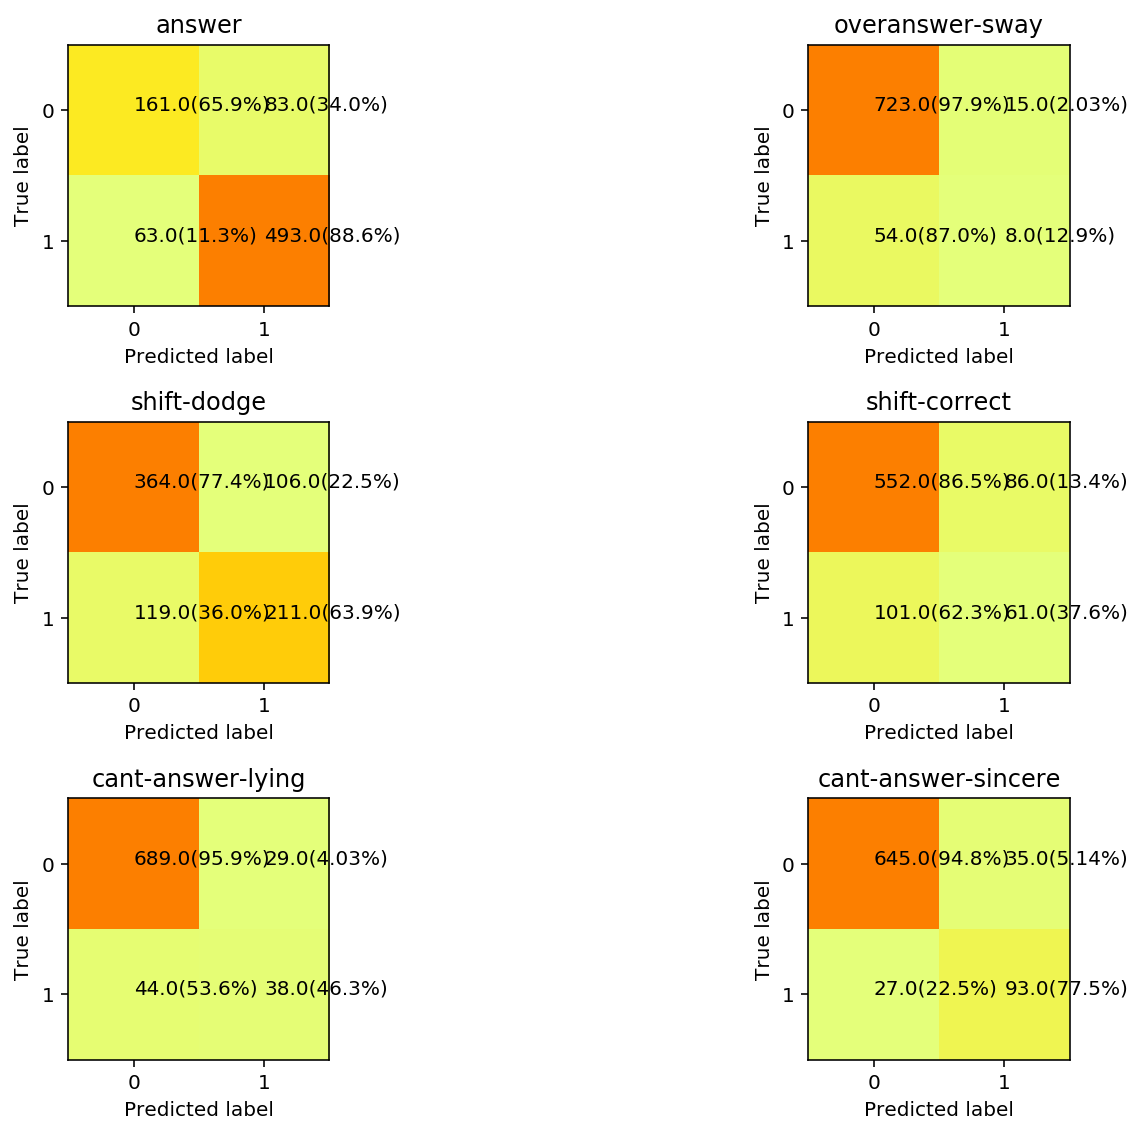

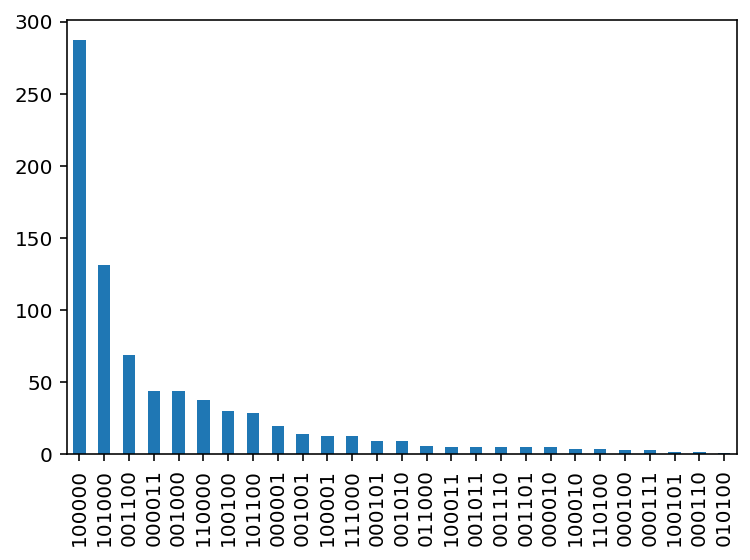

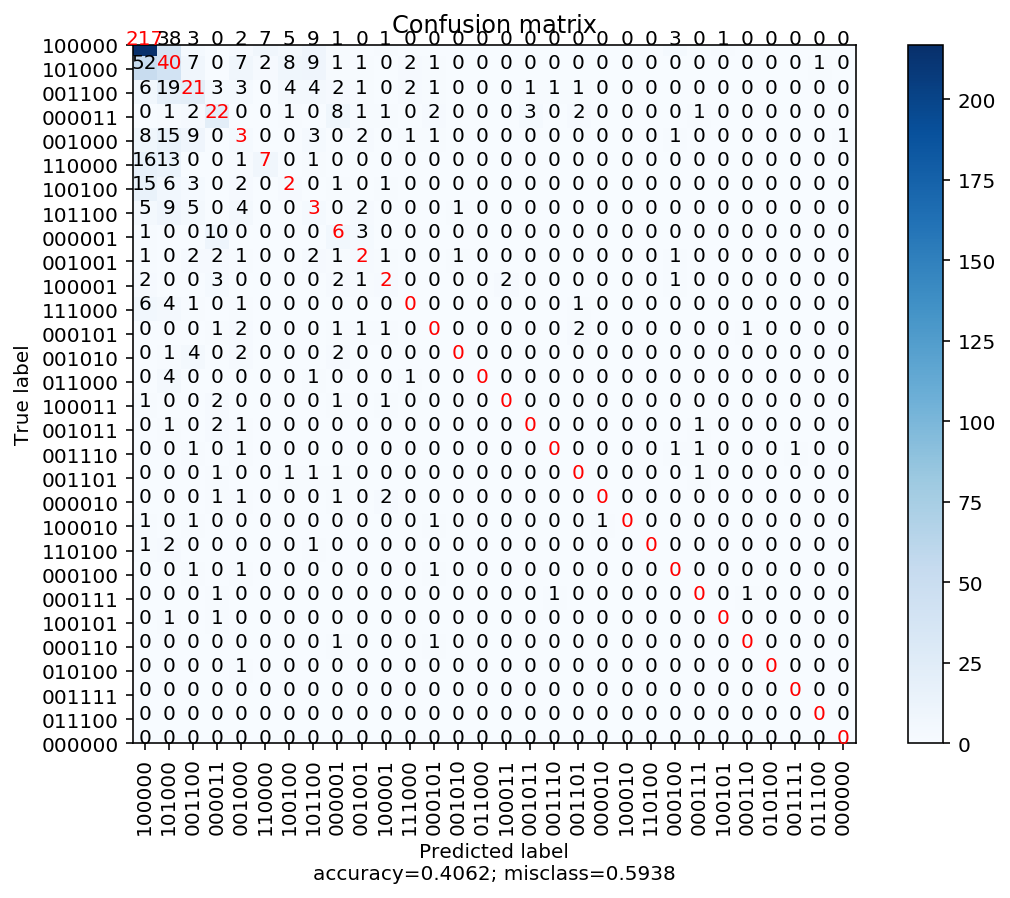

In [6]:
class_labels = ['answer', 'overanswer-sway', 
                'shift-dodge', 'shift-correct', 
                'cant-answer-lying','cant-answer-sincere']
base_files = []
for fold_num in range(4):
    base_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_classification/1_input/metrics_roberta_classification_r_text_test.json_fold'+str(fold_num)+'_test')
base_ids, base_targets, base_preds, base_coarse_targets, base_coarse_preds, base_targets_ordered = get_confusion_matrix(base_files)

In [7]:
all_class_labels = []
all_base_ids = []
all_base_targets = []
all_base_preds = []
for fold in range(len(base_ids)):
    all_class_labels.append(class_labels*(len(base_ids[fold])))
    all_base_ids.append(list(itertools.chain.from_iterable(base_ids[fold])))
    all_base_targets.append(list(itertools.chain.from_iterable(base_targets[fold])))
    all_base_preds.append(list(itertools.chain.from_iterable(base_preds[fold])))
base_dfs=[]
for fold in range(len(base_ids)):
    base_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_base_ids[fold], all_base_targets[fold], all_base_preds[fold]), columns=['label','qa_index','gold','pred']))
    base_dfs[fold]['correct'] = base_dfs[fold]['gold']==base_dfs[fold]['pred']
    base_dfs[fold]['uid'] = base_dfs[fold]['label']+'_'+base_dfs[fold]['qa_index'].astype(str)

In [8]:
incorrect_base_qas=[]
for fold in range(4):
    incorrect_base_qas.extend(base_dfs[fold][base_dfs[fold]['correct']==False]['qa_index'].values)

In [9]:
f1_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_scores.append(metrics.f1_score(fold_targets, fold_preds, average='macro'))
np.mean(np.array(f1_scores))

0.558667169649854

In [10]:
f1_class_scores = []
for fold_targets, fold_preds in zip(base_targets, base_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.87000441, 0.18851852, 0.64881973, 0.38887796, 0.50765382,
       0.74812857])

In [11]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(base_coarse_targets, base_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.87608686, 0.7073296 , 0.78102082])

### Hierarchical

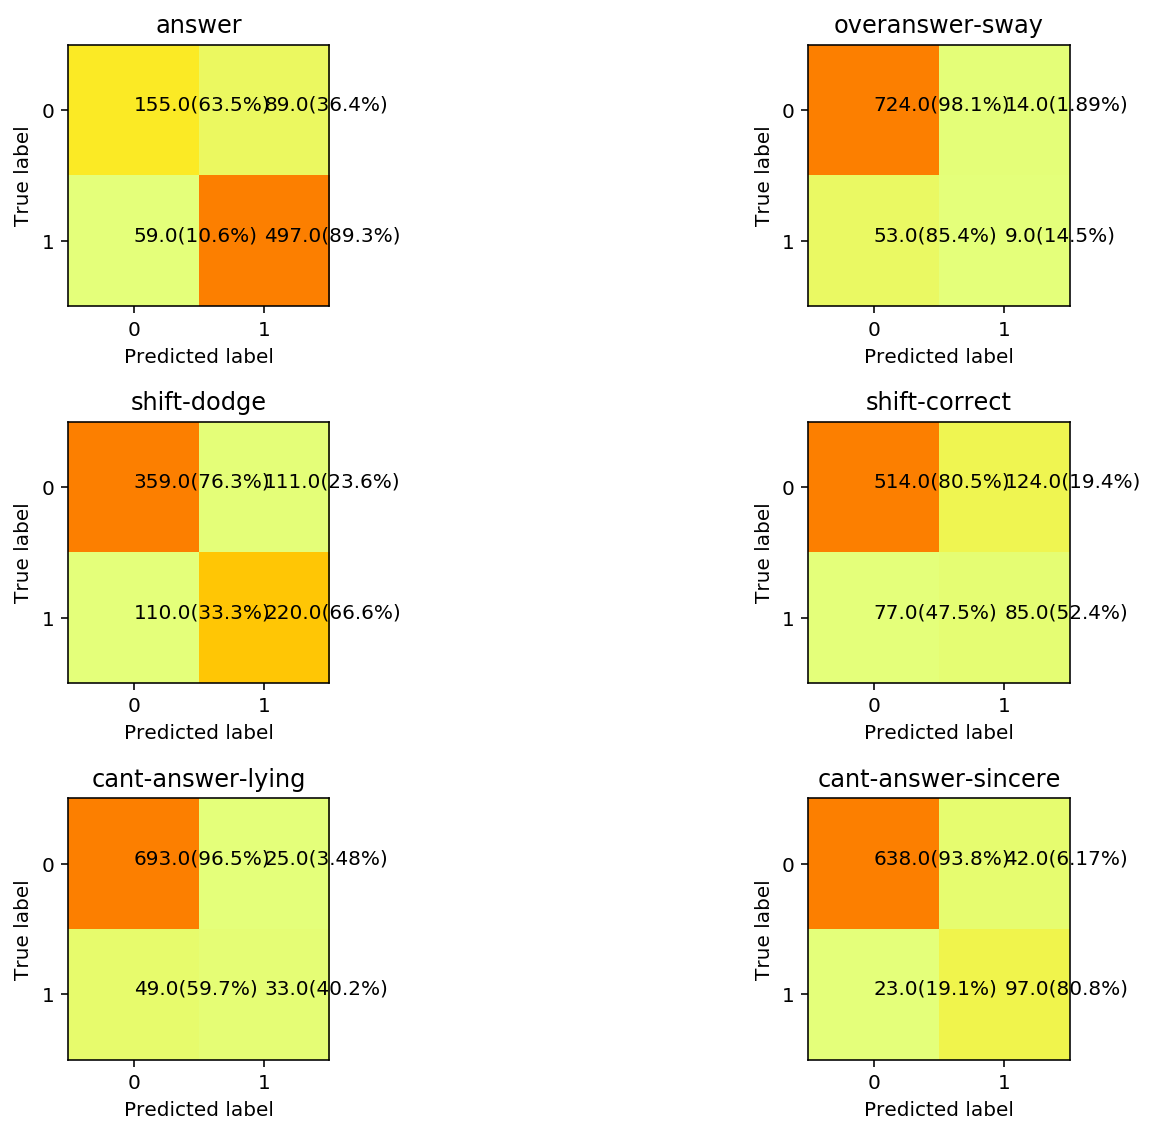

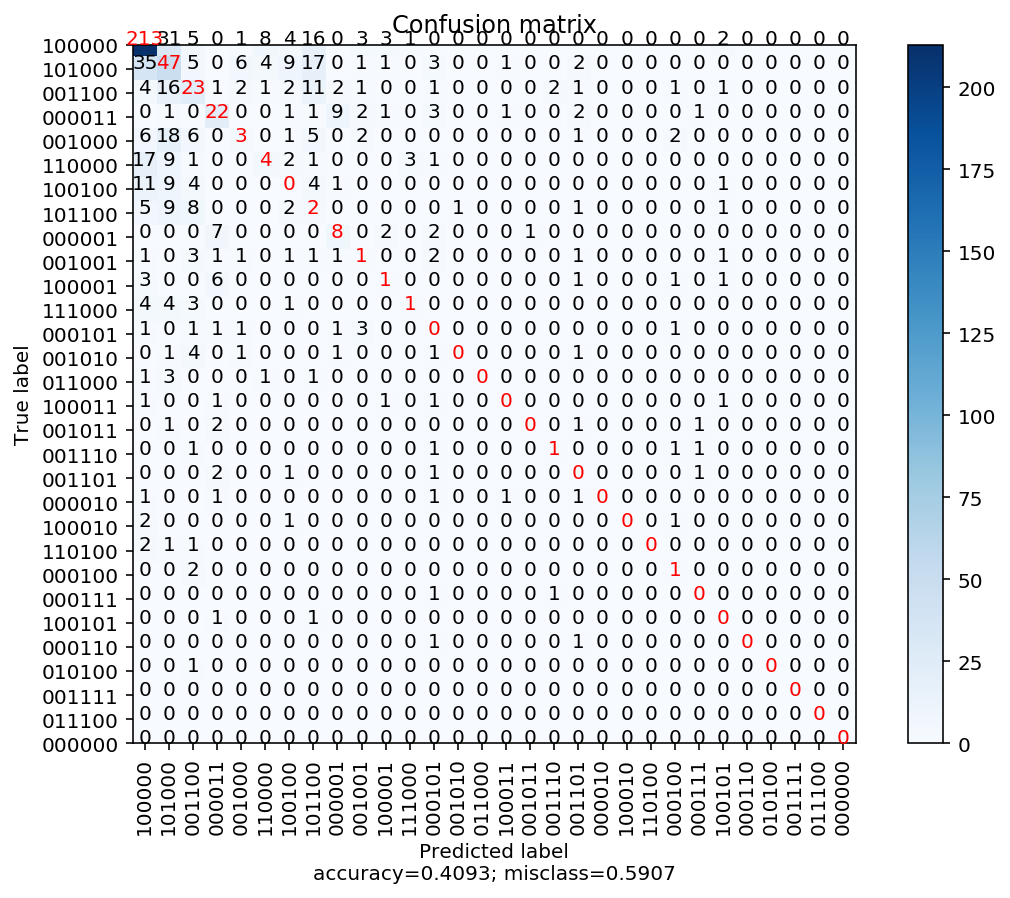

In [12]:
hier_files = []
for fold_num in range(4):
    hier_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/1_input/metrics_roberta_hierarchical_r_text_test.json_fold'+str(fold_num)+'_test_fine')
hier_ids, hier_targets, hier_preds, hier_coarse_targets, hier_coarse_preds, _ = get_confusion_matrix(hier_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [13]:
f1_class_scores = []
for fold_targets, fold_preds in zip(hier_targets, hier_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.869514  , 0.20720085, 0.66121685, 0.45763613, 0.4762531 ,
       0.7519099 ])

In [14]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(hier_coarse_targets, hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.87464755, 0.75129304, 0.7696558 ])

In [15]:
all_class_labels = []
all_hier_ids = []
all_hier_targets = []
all_hier_preds = []
for fold in range(len(hier_ids)):
    all_class_labels.append(class_labels*(len(hier_ids[fold])))
    all_hier_ids.append(list(itertools.chain.from_iterable(hier_ids[fold])))
    all_hier_targets.append(list(itertools.chain.from_iterable(hier_targets[fold])))
    all_hier_preds.append(list(itertools.chain.from_iterable(hier_preds[fold])))
hier_dfs = []
for fold in range(len(hier_ids)):
    hier_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_hier_ids[fold], all_hier_targets[fold], all_hier_preds[fold]), columns=['label','qa_index','gold','pred']))
    hier_dfs[fold]['correct'] = hier_dfs[fold]['gold']==hier_dfs[fold]['pred']
    hier_dfs[fold]['uid'] = hier_dfs[fold]['label']+'_'+hier_dfs[fold]['qa_index'].astype(str)
merged_hier_dfs = []
for fold in range(len(hier_dfs)):
    merged_hier_dfs.append(base_dfs[fold].merge(hier_dfs[fold], on='uid',suffixes=('_base', '_hier')))

In [16]:
for fold in range(len(merged_hier_dfs)):
    print('Fold', fold)
    merged_hier_dfs[fold]['hearing_id'] = merged_hier_dfs[fold]['qa_index_base'].astype(str).str[:8]
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['hearing_id'].value_counts())
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['label_base'].value_counts())

Fold 0


11422125    23
11636001    13
11531504     9
11637282     4
Name: hearing_id, dtype: int64

shift-correct          19
shift-dodge            13
answer                  6
cant-answer-sincere     5
cant-answer-lying       4
overanswer-sway         2
Name: label_base, dtype: int64

Fold 1


11530242    15
11426003    15
11420722    12
11386195    10
Name: hearing_id, dtype: int64

shift-dodge            18
shift-correct          17
cant-answer-sincere     6
answer                  5
overanswer-sway         3
cant-answer-lying       3
Name: label_base, dtype: int64

Fold 2


11531349    21
11532380    13
11635589    11
11393834     6
Name: hearing_id, dtype: int64

shift-dodge            18
shift-correct          10
answer                 10
cant-answer-lying       5
cant-answer-sincere     5
overanswer-sway         3
Name: label_base, dtype: int64

Fold 3


11495063    13
11497630     9
11530956     9
11635230     5
Name: hearing_id, dtype: int64

shift-correct          13
shift-dodge            10
overanswer-sway         7
cant-answer-lying       3
cant-answer-sincere     2
answer                  1
Name: label_base, dtype: int64

In [17]:
for fold in range(4):
    print('Fold', fold)
    display(merged_hier_dfs[fold][(merged_hier_dfs[fold]['label_base']=='shift-correct')&(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)])

Fold 0


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
45,shift-correct,11531504102,1,0,False,shift-correct_11531504102,shift-correct,11531504102,1,1,True,11531504
147,shift-correct,11422125073,0,1,False,shift-correct_11422125073,shift-correct,11422125073,0,0,True,11422125
435,shift-correct,11636001036,0,1,False,shift-correct_11636001036,shift-correct,11636001036,0,0,True,11636001
477,shift-correct,11422125075,1,0,False,shift-correct_11422125075,shift-correct,11422125075,1,1,True,11422125
543,shift-correct,11531504076,0,1,False,shift-correct_11531504076,shift-correct,11531504076,0,0,True,11531504
555,shift-correct,11636001004,1,0,False,shift-correct_11636001004,shift-correct,11636001004,1,1,True,11636001
591,shift-correct,11422125105,1,0,False,shift-correct_11422125105,shift-correct,11422125105,1,1,True,11422125
645,shift-correct,11422125097,1,0,False,shift-correct_11422125097,shift-correct,11422125097,1,1,True,11422125
657,shift-correct,11422125028,0,1,False,shift-correct_11422125028,shift-correct,11422125028,0,0,True,11422125
663,shift-correct,11636001038,0,1,False,shift-correct_11636001038,shift-correct,11636001038,0,0,True,11636001


Fold 1


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
87,shift-correct,11530242097,1,0,False,shift-correct_11530242097,shift-correct,11530242097,1,1,True,11530242
105,shift-correct,11426003004,0,1,False,shift-correct_11426003004,shift-correct,11426003004,0,0,True,11426003
273,shift-correct,11426003043,0,1,False,shift-correct_11426003043,shift-correct,11426003043,0,0,True,11426003
333,shift-correct,11420722127,0,1,False,shift-correct_11420722127,shift-correct,11420722127,0,0,True,11420722
405,shift-correct,11420722125,0,1,False,shift-correct_11420722125,shift-correct,11420722125,0,0,True,11420722
429,shift-correct,11386195094,1,0,False,shift-correct_11386195094,shift-correct,11386195094,1,1,True,11386195
465,shift-correct,11386195014,1,0,False,shift-correct_11386195014,shift-correct,11386195014,1,1,True,11386195
525,shift-correct,11386195034,1,0,False,shift-correct_11386195034,shift-correct,11386195034,1,1,True,11386195
531,shift-correct,11420722133,1,0,False,shift-correct_11420722133,shift-correct,11420722133,1,1,True,11420722
639,shift-correct,11426003023,0,1,False,shift-correct_11426003023,shift-correct,11426003023,0,0,True,11426003


Fold 2


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
117,shift-correct,11532380065,0,1,False,shift-correct_11532380065,shift-correct,11532380065,0,0,True,11532380
147,shift-correct,11531349075,0,1,False,shift-correct_11531349075,shift-correct,11531349075,0,0,True,11531349
165,shift-correct,11531349091,1,0,False,shift-correct_11531349091,shift-correct,11531349091,1,1,True,11531349
219,shift-correct,11531349029,0,1,False,shift-correct_11531349029,shift-correct,11531349029,0,0,True,11531349
291,shift-correct,11635589139,1,0,False,shift-correct_11635589139,shift-correct,11635589139,1,1,True,11635589
333,shift-correct,11531349123,0,1,False,shift-correct_11531349123,shift-correct,11531349123,0,0,True,11531349
915,shift-correct,11393834006,0,1,False,shift-correct_11393834006,shift-correct,11393834006,0,0,True,11393834
951,shift-correct,11393834042,1,0,False,shift-correct_11393834042,shift-correct,11393834042,1,1,True,11393834
975,shift-correct,11531349111,1,0,False,shift-correct_11531349111,shift-correct,11531349111,1,1,True,11531349
1167,shift-correct,11531349065,1,0,False,shift-correct_11531349065,shift-correct,11531349065,1,1,True,11531349


Fold 3


,label_base,qa_index_base,gold_base,pred_base,correct_base,uid,label_hier,qa_index_hier,gold_hier,pred_hier,correct_hier,hearing_id
117,shift-correct,11530956079,1,0,False,shift-correct_11530956079,shift-correct,11530956079,1,1,True,11530956
141,shift-correct,11497630018,0,1,False,shift-correct_11497630018,shift-correct,11497630018,0,0,True,11497630
273,shift-correct,11495063107,1,0,False,shift-correct_11495063107,shift-correct,11495063107,1,1,True,11495063
285,shift-correct,11495063109,1,0,False,shift-correct_11495063109,shift-correct,11495063109,1,1,True,11495063
309,shift-correct,11497630016,0,1,False,shift-correct_11497630016,shift-correct,11497630016,0,0,True,11497630
531,shift-correct,11495063099,1,0,False,shift-correct_11495063099,shift-correct,11495063099,1,1,True,11495063
609,shift-correct,11530956012,0,1,False,shift-correct_11530956012,shift-correct,11530956012,0,0,True,11530956
735,shift-correct,11495063021,1,0,False,shift-correct_11495063021,shift-correct,11495063021,1,1,True,11495063
939,shift-correct,11530956069,1,0,False,shift-correct_11530956069,shift-correct,11530956069,1,1,True,11530956
957,shift-correct,11495063048,1,0,False,shift-correct_11495063048,shift-correct,11495063048,1,1,True,11495063


In [20]:
corrected_hier_qas = []
for fold in range(4):
    corrected_hier_qas.extend(merged_hier_dfs[fold][(merged_hier_dfs[fold]['label_base']=='shift-correct')&(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['qa_index_base'])

### Question

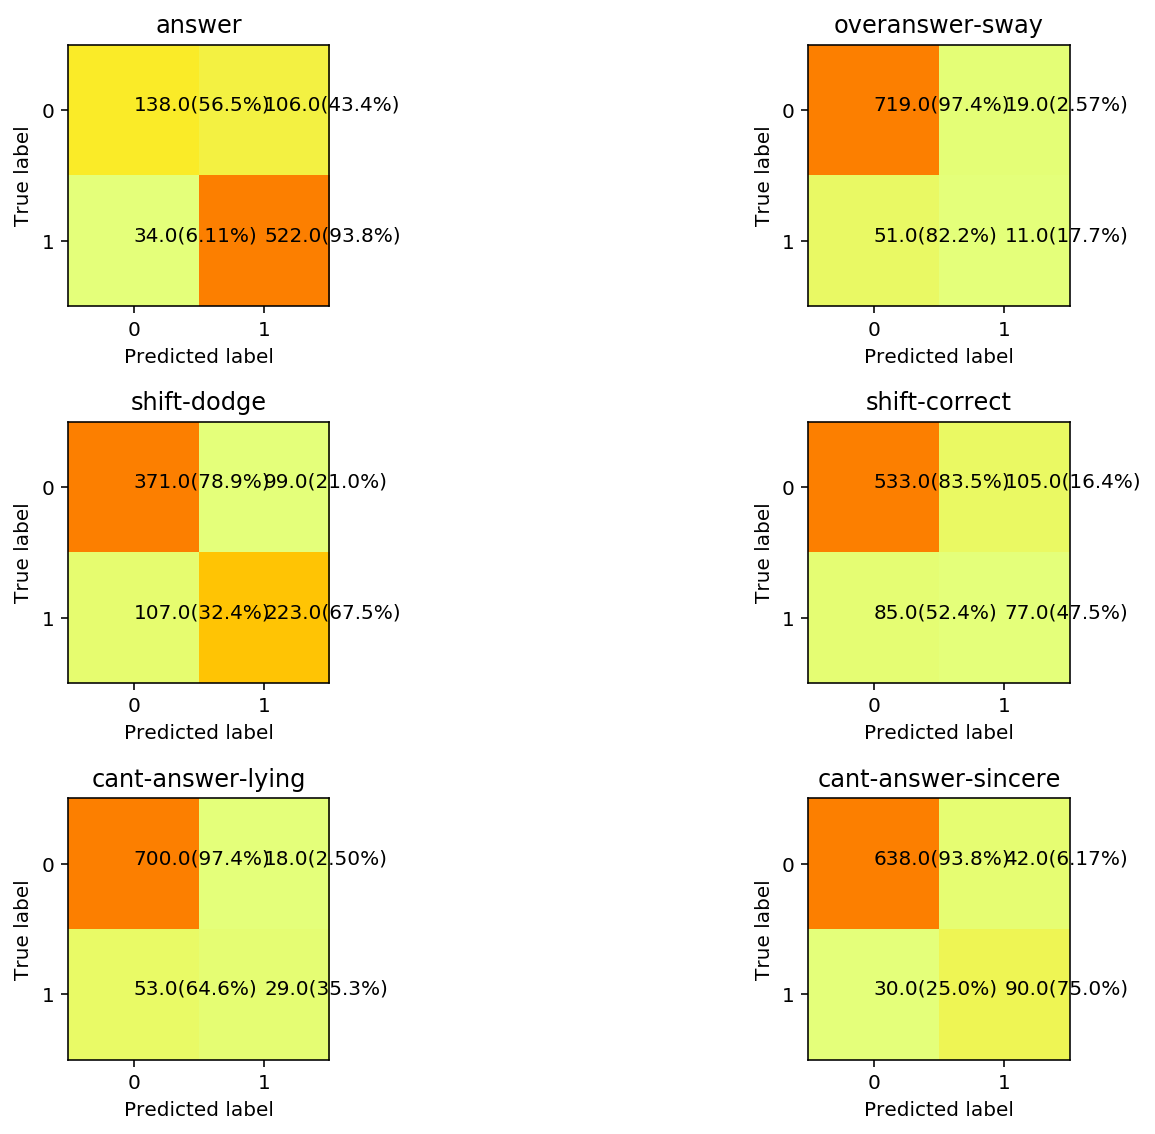

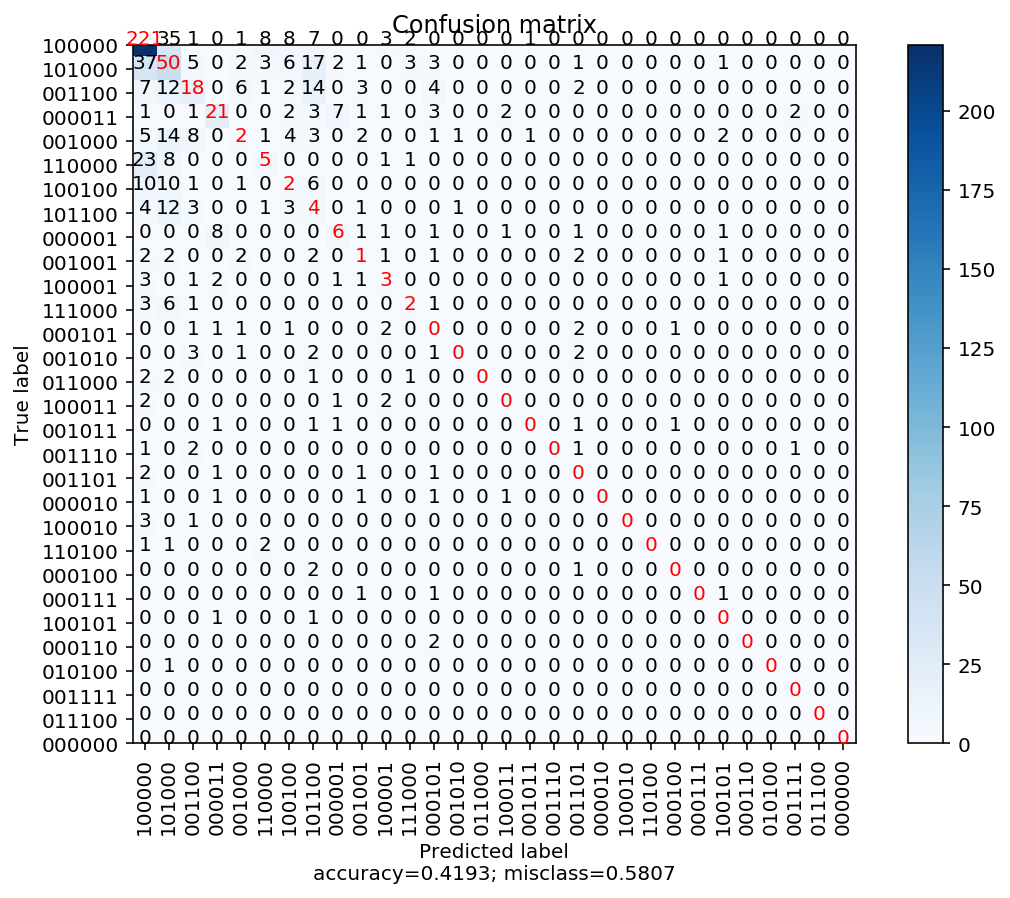

In [23]:
last_q_files = []
for fold_num in range(4):
    last_q_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results_final/roberta_hierarchical/2_input/metrics_roberta_hierarchical_q_text_first_question_and_rest_r_text_test.json_fold'+str(fold_num)+'_test_fine')
last_q_ids, last_q_targets, last_q_preds, last_q_coarse_targets, last_q_coarse_preds, _ = get_confusion_matrix(last_q_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [24]:
f1_class_scores = []
for fold_targets, fold_preds in zip(last_q_targets, last_q_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

array([0.88115165, 0.23808275, 0.67236608, 0.44603285, 0.46877585,
       0.72282393])

In [25]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(last_q_coarse_targets, last_q_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

array([0.88774111, 0.76141896, 0.73894817])

In [26]:
all_class_labels = []
all_last_q_ids = []
all_last_q_targets = []
all_last_q_preds = []
for fold in range(len(last_q_ids)):
    all_class_labels.append(class_labels*(len(last_q_ids[fold])))
    all_last_q_ids.append(list(itertools.chain.from_iterable(last_q_ids[fold])))
    all_last_q_targets.append(list(itertools.chain.from_iterable(last_q_targets[fold])))
    all_last_q_preds.append(list(itertools.chain.from_iterable(last_q_preds[fold])))
last_q_dfs = []
for fold in range(len(last_q_ids)):
    last_q_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_last_q_ids[fold], all_last_q_targets[fold], all_last_q_preds[fold]), columns=['label','qa_index','gold','pred']))
    last_q_dfs[fold]['correct'] = last_q_dfs[fold]['gold']==last_q_dfs[fold]['pred']
    last_q_dfs[fold]['uid'] = last_q_dfs[fold]['label']+'_'+last_q_dfs[fold]['qa_index'].astype(str)
merged_last_q_dfs = []
for fold in range(len(last_q_dfs)):
    merged_last_q_dfs.append(hier_dfs[fold].merge(last_q_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_last_q')))

In [30]:
incorrect_lastq_cantans_qas = []
for fold in range(len(merged_last_q_dfs)):
    print('Fold', fold)
    merged_last_q_dfs[fold]['hearing_id'] = merged_last_q_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['hearing_id'].value_counts())
    display(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==False) & (merged_last_q_dfs[fold]['correct_hier_last_q']==True)]['label_hier_base'].value_counts())
    incorrect_lastq_cantans_qas.extend(merged_last_q_dfs[fold][(merged_last_q_dfs[fold]['correct_hier_base']==True) & (merged_last_q_dfs[fold]['label_hier_base'].str.startswith('cant-answer')) & (merged_last_q_dfs[fold]['correct_hier_last_q']==False)]['qa_index_hier_base'])

Fold 0


11636001    29
11422125    15
11531504    14
11637282    12
Name: hearing_id, dtype: int64

shift-correct          24
shift-dodge            22
answer                 14
cant-answer-lying       6
overanswer-sway         2
cant-answer-sincere     2
Name: label_hier_base, dtype: int64

Fold 1


11386195    24
11420722    20
11530242    19
11426003     9
Name: hearing_id, dtype: int64

shift-dodge            28
shift-correct          26
answer                  7
cant-answer-lying       6
cant-answer-sincere     3
overanswer-sway         2
Name: label_hier_base, dtype: int64

Fold 2


11531349    20
11532380    11
11393834    10
11635589    10
Name: hearing_id, dtype: int64

shift-dodge            15
shift-correct          14
answer                 10
overanswer-sway         6
cant-answer-sincere     4
cant-answer-lying       2
Name: label_hier_base, dtype: int64

Fold 3


11635230    20
11497630    18
11495063    13
11530956    13
Name: hearing_id, dtype: int64

shift-dodge            20
shift-correct          15
answer                 12
cant-answer-lying       7
overanswer-sway         5
cant-answer-sincere     5
Name: label_hier_base, dtype: int64

In [31]:
incorrect_lastq_cantans_qas

[11422125006,
 11636001100,
 11636001030,
 11422125085,
 11636001014,
 11636001014,
 11636001159,
 11531504017,
 11422125083,
 11636001051,
 11422125105,
 11422125071,
 11636001169,
 11422125111,
 11636001121,
 11422125061,
 11636001010,
 11637282100,
 11386195082,
 11386195084,
 11426003099,
 11530242125,
 11386195002,
 11426003079,
 11531349037,
 11531349075,
 11393834097,
 11531349103,
 11635589147,
 11635589147,
 11531349000,
 11531349105,
 11531349105,
 11495063101,
 11495063027,
 11495063021,
 11497630118,
 11635230103,
 11530956127]

## Sentiment

In [ ]:
sent_files = []
for fold_num in range(4):
    sent_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/2_input/metrics_roberta_hierarchical_gold_sentiments_coarse_num_r_text_test.json_fold'+str(fold_num)+'_test_fine')
sent_ids, sent_targets, sent_preds, sent_coarse_targets, sent_coarse_preds, _ = get_confusion_matrix(sent_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
f1_class_scores = []
for fold_targets, fold_preds in zip(sent_targets, sent_preds):
    f1_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_class_scores)).mean(axis=0)

In [ ]:
f1_coarse_class_scores = []
for fold_targets, fold_preds in zip(hier_coarse_targets, hier_coarse_preds):
    f1_coarse_class_scores.append(metrics.precision_recall_fscore_support(fold_targets, fold_preds)[2])
(np.vstack(f1_coarse_class_scores)).mean(axis=0)

In [ ]:
all_class_labels = []
all_sent_ids = []
all_sent_targets = []
all_sent_preds = []
for fold in range(len(sent_ids)):
    all_class_labels.append(class_labels*(len(sent_ids[fold])))
    all_sent_ids.append(list(itertools.chain.from_iterable(sent_ids[fold])))
    all_sent_targets.append(list(itertools.chain.from_iterable(sent_targets[fold])))
    all_sent_preds.append(list(itertools.chain.from_iterable(sent_preds[fold])))
sent_dfs = []
for fold in range(len(sent_ids)):
    sent_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_ids[fold], all_sent_targets[fold], all_sent_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_dfs[fold]['correct'] = sent_dfs[fold]['gold']==sent_dfs[fold]['pred']
    sent_dfs[fold]['uid'] = sent_dfs[fold]['label']+'_'+sent_dfs[fold]['qa_index'].astype(str)
merged_sent_dfs = []
for fold in range(len(sent_dfs)):
    merged_sent_dfs.append(hier_dfs[fold].merge(sent_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent')))

In [ ]:
for fold in range(len(merged_sent_dfs)):
    print('Fold', fold)
    merged_sent_dfs[fold]['hearing_id'] = merged_sent_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['hearing_id'].value_counts())
    display(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['label_hier_base'].value_counts())

In [ ]:
fold=0
qa_indices = merged_sent_dfs[fold][(merged_sent_dfs[fold]['label_base']=='shift-dodge')&(merged_sent_dfs[fold]['correct_base']==False) & (merged_sent_dfs[fold]['correct_sent']==True)]['qa_index_base'].values

In [ ]:
merged_sent_dfs[fold][(merged_sent_dfs[fold]['qa_index_base'].isin(qa_indices))&(merged_sent_dfs[fold]['correct_base']==False)][['label_base','qa_index_base','gold_base','pred_base','pred_sent']]

In [ ]:
fold=3
merged_sent_dfs[fold][merged_sent_dfs[fold]['qa_index_hier_base']==11530956014]

## Sentiment+Last question

In [ ]:
sent_quest_files = []
for fold_num in range(4):
    sent_quest_files.append('/Users/elisa/Documents/CompLing/congressional_hearing/results/roberta_classification/roberta_test_hier/3_input/metrics_roberta_hierarchical_r_text_gold_sentiments_coarse_num_q_text_last_question_test.json_fold'+str(fold_num)+'_test_fine')
sent_quest_ids, sent_quest_targets, sent_quest_preds, sent_quest_coarse_targets, sent_quest_coarse_preds, _ = get_confusion_matrix(sent_quest_files, is_fine=True, all_label_sets_ordered=base_targets_ordered)

In [ ]:
all_class_labels = []
all_sent_quest_ids = []
all_sent_quest_targets = []
all_sent_quest_preds = []
for fold in range(len(sent_quest_ids)):
    all_class_labels.append(class_labels*(len(sent_quest_ids[fold])))
    all_sent_quest_ids.append(list(itertools.chain.from_iterable(sent_quest_ids[fold])))
    all_sent_quest_targets.append(list(itertools.chain.from_iterable(sent_quest_targets[fold])))
    all_sent_quest_preds.append(list(itertools.chain.from_iterable(sent_quest_preds[fold])))
sent_quest_dfs = []
for fold in range(len(sent_quest_ids)):
    sent_quest_dfs.append(pd.DataFrame(zip(all_class_labels[fold], all_sent_quest_ids[fold], all_sent_quest_targets[fold], all_sent_quest_preds[fold]), columns=['label','qa_index','gold','pred']))
    sent_quest_dfs[fold]['correct'] = sent_quest_dfs[fold]['gold']==sent_quest_dfs[fold]['pred']
    sent_quest_dfs[fold]['uid'] = sent_quest_dfs[fold]['label']+'_'+sent_quest_dfs[fold]['qa_index'].astype(str)
merged_sent_quest_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_dfs.append(hier_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_base', '_hier_sent_quest')))

In [ ]:
for fold in range(len(merged_sent_quest_dfs)):
    print('Fold', fold)
    merged_sent_quest_dfs[fold]['hearing_id'] = merged_sent_quest_dfs[fold]['qa_index_hier_base'].astype(str).str[:8]
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_base'].value_counts())

In [ ]:
corrected_sent_quest_qas=[]
all_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_dfs[fold][(merged_sent_quest_dfs[fold]['correct_hier_base']==False) & (merged_sent_quest_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_base'].values)
    all_sent_quest_qas.extend(merged_sent_quest_dfs[fold]['qa_index_hier_base'].values)

In [ ]:
corrected_sent_qas=[]
for fold in range(4):
    corrected_sent_qas.extend(merged_sent_dfs[fold][(merged_sent_dfs[fold]['correct_hier_base']==False) & (merged_sent_dfs[fold]['correct_hier_sent']==True)]['qa_index_hier_base'].values)

In [ ]:
corrected_hierarchical_qas=[]
for fold in range(4):
    corrected_hierarchical_qas.extend(merged_hier_dfs[fold][(merged_hier_dfs[fold]['correct_base']==False) & (merged_hier_dfs[fold]['correct_hier']==True)]['qa_index_hier'].values)

### Sent+quest vs Sent only

In [ ]:
merged_sent_quest_sent_dfs = []
for fold in range(len(sent_quest_dfs)):
    merged_sent_quest_sent_dfs.append(sent_dfs[fold].merge(sent_quest_dfs[fold], on='uid',suffixes=('_hier_sent', '_hier_sent_quest')))
for fold in range(len(merged_sent_quest_sent_dfs)):
    print('Fold', fold)
    merged_sent_quest_sent_dfs[fold]['hearing_id'] = merged_sent_quest_sent_dfs[fold]['qa_index_hier_sent'].astype(str).str[:8]
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['hearing_id'].value_counts())
    display(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['label_hier_sent'].value_counts())

In [ ]:
fold=0
shift_correct_df = merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['label_hier_sent']=='shift-correct')&(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)][['label_hier_sent','qa_index_hier_sent','gold_hier_sent','pred_hier_sent','pred_hier_sent_quest','label_hier_sent_quest']]
shift_correct_df

In [ ]:
merged_sent_quest_sent_dfs[0][merged_sent_quest_sent_dfs[0]['qa_index_sent']==11531417008]

In [ ]:
qa=11426003041#11495063113#11426003004#11525545112
fold=2
merged_sent_quest_sent_dfs[fold][merged_sent_quest_sent_dfs[fold]['qa_index_sent']==qa][['label_sent','qa_index_sent','gold_sent','pred_sent','pred_sent_quest','label_sent_quest']]

In [ ]:
base_dfs[fold][base_dfs[fold]['qa_index']==qa]

In [ ]:
corrected_sent_quest_qas=[]
for fold in range(4):
    corrected_sent_quest_qas.extend(merged_sent_quest_sent_dfs[fold][(merged_sent_quest_sent_dfs[fold]['correct_hier_sent']==False) & (merged_sent_quest_sent_dfs[fold]['correct_hier_sent_quest']==True)]['qa_index_hier_sent'].values)

In [ ]:
(set(corrected_sent_quest_qas).intersection(set(corrected_sent_qas))).intersection(set(corrected_hierarchical_qas))#.intersection(set(incorrect_base_qas))

In [ ]:
set(corrected_hierarchical_qas)

In [ ]:
'11637282132'[-3:]

In [ ]:
def qa_to_index(qa):
    qa = str(qa)
    congr = qa[:3]
    hrg = qa[3:8]
    qnum = qa[-3:]
    index = 'CHRG-'+congr+'hhrg'+hrg+'_'+qnum
    return index

In [ ]:
corr_qas = []
all_qas = []
for qa in corrected_sent_quest_qas:
    corr_qas.append(qa_to_index(qa))
for qa in all_sent_quest_qas:
    all_qas.append(qa_to_index(qa))

In [ ]:
set(corr_qas)

In [ ]:
set(all_qas)